# Challenge: Multivariate Regression #

### Create a Multivariate Regression Model from Crime Data ###

### By Lorenz Madarang ###

### Data: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls ###

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation
from collections import Counter
import operator
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format



### Upload Crime Data and Initial Look at the Data ###
There are a lot of NAs in the data.  The data needs to be cleaned.  And as stated in the Data Prep drill, new features need to be created.  

In [3]:
file = 'NewYork_Crime.xlsx'

In [4]:
nycrime = pd.ExcelFile(file)

In [5]:
df = nycrime.parse('Sheet1')

In [6]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
City                                    348 non-null object
Population                              348 non-null int64
Violent
crime                           348 non-null int64
Murder and
nonnegligent
manslaughter    348 non-null int64
Rape
(revised
definition)1              0 non-null float64
Rape
(legacy
definition)2               348 non-null int64
Robbery                                 348 non-null int64
Aggravated
assault                      348 non-null int64
Property
crime                          348 non-null int64
Burglary                                348 non-null int64
Larceny-
theft                          348 non-null int64
Motor
vehicle
theft                     348 non-null int64
Arson3                                  187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 35.4+ KB


### Cleaning of the Data and Feature Engineering ###
For the data cleaning I replaced all the NA values with 0.  Also, I created a new features:
    1. 'Pop_squared' = Population Squared
    2. 'Murder_cat' = Binary feature, (0 = no murder, 1 = has murder
    3. 'Robbery_cat' = Binary feature,(0 = no robbery, 1 = has robbery 

In [25]:
df = df.fillna(value=0)

In [26]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Pop_squared,Murder_cat,Robbery_cat
0,Adams Village,1861,0,0,0.000,0,0,0,12,2,10,0,0.000,3463321,0.000,0.000
1,Addison Town and Village,2577,3,0,0.000,0,0,3,24,3,20,1,0.000,6640929,0.000,0.000
2,Akron Village,2846,3,0,0.000,0,0,3,16,1,15,0,0.000,8099716,0.000,0.000
3,Albany,97956,791,8,0.000,30,227,526,4090,705,3243,142,0.000,9595377936,1.000,1.000
4,Albion Village,6388,23,0,0.000,3,4,16,223,53,165,5,0.000,40806544,0.000,1.000


In [9]:
df['Pop_squared']=(df['Population']*df['Population'])

In [10]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Pop_squared
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0,3463321
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0,6640929
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0,8099716
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN,9595377936
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN,40806544


In [11]:
for i in range(len(df)):
    if df.loc[i, 'Murder and\nnonnegligent\nmanslaughter'] == 0:
        df.loc[i, 'Murder_cat'] = 0
    else:
        df.loc[i, 'Murder_cat'] = 1
    if df.loc[i, 'Robbery'] == 0:
        df.loc[i, 'Robbery_cat'] = 0
    else:
        df.loc[i, 'Robbery_cat'] =1 


In [27]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Pop_squared,Murder_cat,Robbery_cat
0,Adams Village,1861,0,0,0.000,0,0,0,12,2,10,0,0.000,3463321,0.000,0.000
1,Addison Town and Village,2577,3,0,0.000,0,0,3,24,3,20,1,0.000,6640929,0.000,0.000
2,Akron Village,2846,3,0,0.000,0,0,3,16,1,15,0,0.000,8099716,0.000,0.000
3,Albany,97956,791,8,0.000,30,227,526,4090,705,3243,142,0.000,9595377936,1.000,1.000
4,Albion Village,6388,23,0,0.000,3,4,16,223,53,165,5,0.000,40806544,0.000,1.000


### Multivariate Linear Regression Model ###
After looking at the heatmap of the correlation of the variables, it shows that a lot of the variables are highly correlated with each other.  So I created a multivariate linear regression model with essentially all of the variables except the 'Pop_squared', 'Robbery_cat', and "Murder_cat'. 

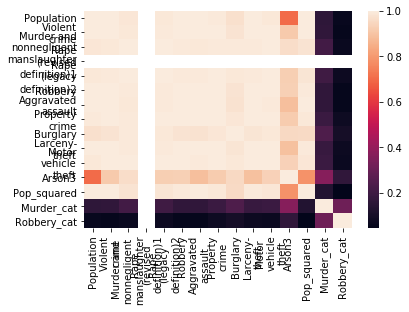

In [13]:
sns.heatmap(df.corr())

In [16]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Pop_squared',
       'Murder_cat', 'Robbery_cat'],
      dtype='object')

In [22]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property\ncrime'].values.reshape(-1, 1)
X = df[['Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
        'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Pop_squared']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  7.64346176e-17  -2.84872651e-08   2.84871966e-08   2.84871988e-08
    2.84872877e-08   2.84872603e-08   1.00000000e+00   1.00000000e+00
    1.00000000e+00  -5.46823100e-24]]

Intercept: 
 [ -2.95585778e-12]

R-squared:
1.0


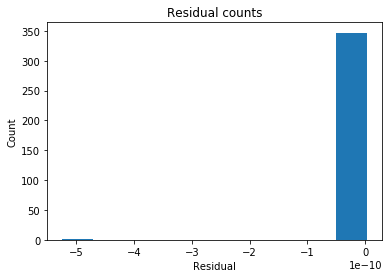

In [23]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Property\ncrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

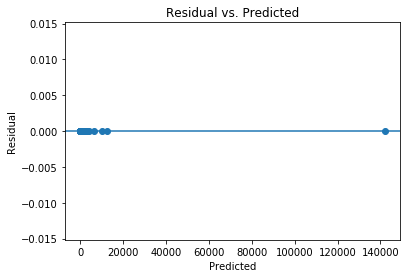

In [24]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

### Overall Evaluation of the Model ###
Essentially, the model is able to account for all of the variance.  The Residuals are very low.  Almost all of the continuous variables were included in the model.  This model may account for all of the variance but it is quite possible that I overfitted the model.  This overfit model might not be able hold up against test data. 